# sell-short-in-may-and-go-away

see: https://en.wikipedia.org/wiki/Sell_in_May

algo  - Sell short in May and go away, buy to cover in Nov  
algo2 - first trading day of the month, adjust position to 50%  
(select the one you want to call in the Strategy.run() function

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
capital = 10000
start = datetime.datetime(2015, 10, 30)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Define Strategy Class

In [5]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end

    def _algo(self):
        pf.TradeLog.cash = self.capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)
            shares = 0

            # buy to cover (at the open on first trading day in Nov)
            if self.tlog.shares > 0:
                if row.month == 11 and row.first_dotm or end_flag:
                    shares = self.tlog.buy2cover(date, row.open)

            # sell short (at the open on first trading day in May)
            else:
                if row.month == 5 and row.first_dotm:
                    shares = self.tlog.sell_short(date, row.open)

            if shares > 0:
                pf.DBG("{0} SELL SHORT  {1} {2} @ {3:.2f}".format(
                       date, shares, self.symbol, row.open))
            elif shares < 0:
                pf.DBG("{0} BUY TO COVER {1} {2} @ {3:.2f}".format(
                       date, -shares, self.symbol, row.open))
            # record daily balance
            self.dbal.append(date, high, low, close)

    def _algo2(self):
        pf.TradeLog.cash = self.capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)
            shares = 0

            # on the first day of the month, adjust short position to 50%
            if (row.first_dotm or end_flag):
                weight = 0 if end_flag else 0.5
                self.tlog.adjust_percent(date, close, weight, pf.Direction.SHORT)

            # record daily balance
            self.dbal.append(date, high, low, close)

    def run(self):
        self.ts = pf.fetch_timeseries(self.symbol)
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end,
                                         use_adj=True)
        # add calendar columns
        self.ts = pf.calendar(self.ts)
        
        self.tlog = pf.TradeLog(self.symbol)
        self.dbal = pf.DailyBal()
        
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start)

        self._algo()
        #self._algo2()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)
        return stats

Run Strategy

In [6]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [7]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [8]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2016-05-02,0,190.40,52,entry,SHRT,SPY
1,2016-11-01,1,197.95,52,exit,SHRT,SPY
2,2017-05-01,2,224.16,42,entry,SHRT,SPY
3,2017-11-01,3,244.74,42,exit,SHRT,SPY
4,2018-05-01,4,252.55,34,entry,SHRT,SPY
5,2018-11-01,5,262.30,34,exit,SHRT,SPY
6,2019-05-01,6,287.55,29,entry,SHRT,SPY
7,2019-11-01,7,300.33,29,exit,SHRT,SPY
8,2020-05-01,8,284.06,28,entry,SHRT,SPY
9,2020-08-21,9,337.92,28,exit,SHRT,SPY


In [9]:
tlog.head(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
0,2016-05-02,190.40,2016-11-01,197.95,-7.54,-392.29,52,-392.29,SHRT,SPY
1,2017-05-01,224.16,2017-11-01,244.74,-20.57,-864.07,42,-1256.36,SHRT,SPY
2,2018-05-01,252.55,2018-11-01,262.30,-9.75,-331.43,34,-1587.79,SHRT,SPY
3,2019-05-01,287.55,2019-11-01,300.33,-12.78,-370.61,29,-1958.39,SHRT,SPY
4,2020-05-01,284.06,2020-08-21,337.92,-53.86,-1508.08,28,-3466.47,SHRT,SPY


In [10]:
dbal.tail(10)

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-08-10,6672.41,6593.73,6599.33,28,87.93,1.00,-
2020-08-11,6699.01,6544.17,6676.89,28,87.93,1.00,-
2020-08-12,6603.81,6523.45,6546.97,28,87.93,1.00,-
2020-08-13,6592.05,6524.29,6564.05,28,87.93,1.00,-
2020-08-14,6597.93,6547.53,6563.77,28,87.93,1.00,-
2020-08-17,6563.49,6521.77,6533.81,28,87.93,1.00,-
2020-08-18,6570.21,6500.49,6513.37,28,87.93,1.00,-
2020-08-19,6569.93,6486.21,6552.85,28,87.93,1.00,-
2020-08-20,6609.13,6508.89,6523.45,28,87.93,1.00,-


In [11]:
pf.print_full(stats)

start                                                  2015-10-30
end                                                    2020-08-21
beginning_balance                                           10000
ending_balance                                            6533.53
total_net_profit                                         -3466.47
gross_profit                                                 0.00
gross_loss                                               -3466.47
profit_factor                                                   0
return_on_initial_capital                                  -34.66
annual_return_rate                                          -8.47
trading_period                           4 years 9 months 22 days
pct_time_in_market                                          49.05
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [12]:
benchmark = pf.Benchmark(symbol, capital, s.start, s.end)
benchmark.run()
benchmark.tlog, benchmark.dbal = benchmark.get_logs()
benchmark.stats = benchmark.get_stats()

2015-10-30 00:00:00 BUY  48 SPY @ 207.93
2020-08-21 00:00:00 SELL 48 SPY @ 339.48


Plot Equity Curves: Strategy vs Benchmark

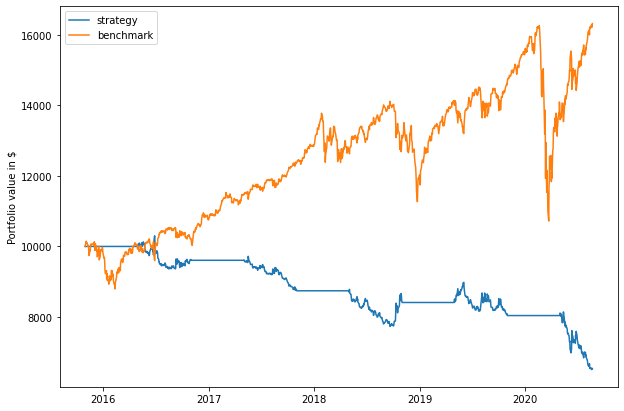

In [13]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

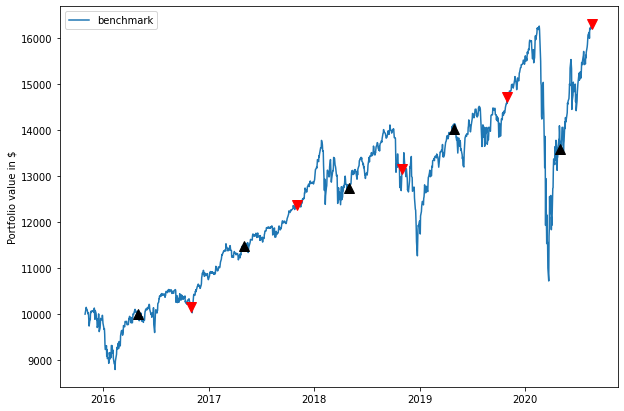

In [14]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,-8.47,10.71
max_closed_out_drawdown,-36.77,-34.06
drawdown_annualized_return,4.34,-3.18
drawdown_recovery,-4.14,-0.09
best_month,11.81,23.03
worst_month,-11.26,-31.35
sharpe_ratio,-0.87,0.64
sortino_ratio,-1.04,0.70
monthly_std,2.33,4.77
annual_std,5.41,8.39


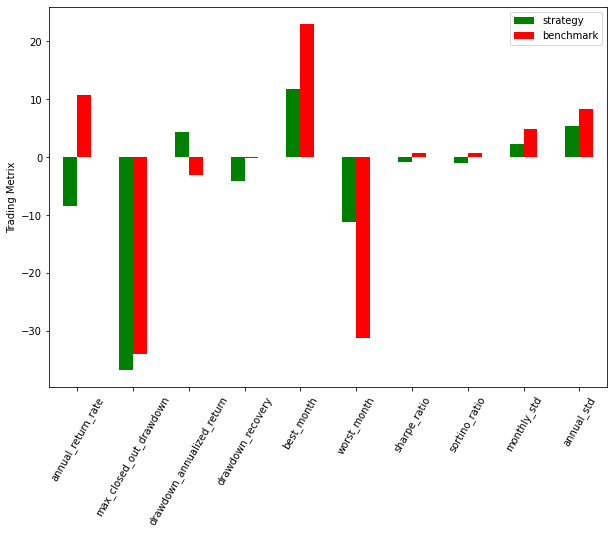

In [15]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df